# Module 6: CFA
# Investment Use Case: Avoiding Biases in Investment models using Machine Learning
# =========================================================

This use case develops three equities selection models in a global equities universe.
- **Traditional quant:** First, we examine the risk of biases of traditional quant models, based on a linear factor approach, identifying problematic assumptions and violations.
- **Hybrid Machine Learning/quant:** Second, we "enhance" the traditional approach using machine learning (ML): traditional quant+ML. We will see that this presents additional risks and biases, as we attempt to improve a traditional quant model using a neural net.
- **Interpretable machine learning equities selection**: Third, we examine a purpose designed ML approach, designed to address many of the possible biases in both traditional quant and traditional quant+ML.

### Code Repositories

Get key packages, download data and get in good shape.

In [1]:
# package for working with tabular data
import pandas as pd
import numpy as np

# package for navigating the operating system
import os

# Progress bar
from tqdm.notebook import tqdm

# Pretty dataframe printing for this notebook
from IPython.display import Markdown, display

# Suppress warnings for demonstration purposes...
import warnings

# Type checking
import numbers

# Filter out the specific warning message
import warnings
warnings.filterwarnings('ignore', 'The `ipykernel.comm.Comm` class has been deprecated.*')


## Github Repo
Many of the functions we use in this notebook are wrapped up in functional classes on the in the Investment-SAI repository, and some in the FinGov repository. For students with coding background and the interest, we encourage you to review these classes and functions.

In [2]:
# install the key packages...
!pip install investsai -q
!pip install InvestmentToolkit
!git clone https://github.com/danphilps/FinGov.git
!pip install shap
!pip install --upgrade ipython ipykernel notebook # Prevents warning messages

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


Cloning into 'FinGov'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 474 (delta 40), reused 0 (delta 0), pack-reused 401
Receiving objects: 100% (474/474), 226.20 KiB | 4.27 MiB/s, done.
Resolving deltas: 100% (284/284), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
# Dependency: We may have to install SHAP, an explainable AI (XAI) package onto your machine (or your Google Colab session if you are running this notebook in Colabl)
import shap

# Now import the objects from the repo
os.chdir('FinGov')
from GovernanceUtils import GovernanceUtils
from FairnessUtils import FairnessUtils
import CFACreditUseCaseUtils
os.chdir('..')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Install SAI and other packages we will need

In [4]:
# Import classes of the InvestmentToolkit which has key utility functions we will use in this notebook
from InvestmentToolkit.itk import SimulationUtils
from InvestmentToolkit.itk import RobustInvestmentUtils
from InvestmentToolkit.itk import LinearFactorInvesting
from InvestmentToolkit.itk import NonLinearFactorInvesting
from InvestmentToolkit.itk import SAIInvesting

# Stage1: Business Case

We need to define a ground truth, then hypotheses and then design an experimental setup to test them. In this notebook our ground truth is simply securities that generate higher returns. Note that this is prone to bias, as we may have more objectives than just outright return delivery.

# Stage2: Data

We will use a subset of a US small cap equities universe, defined as US equities with a market cap between aproximately \\$ 150m and \\$ 3bn, removing equities with incomplete data. Note that by removing equities we may expose ourselves to survivorship bias. We will use 10years of fundamental and pricing data.
First we pull in the data we need, wrangle it, examine it and prepare it.


## Stage2a. Load Data


Get returns and fundamentals for our universe and load into DataFrames

In [5]:
# Get from the shared GoogleDrive
!gdown --folder "https://drive.google.com/drive/folders/1-LFYjc6HI8C6EfGLp26V1aji6Y7SIv0D?usp=sharing"

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Retrieving folder list
Processing file 1-OBDec_7LNSTcB3F65eXszw3-vsrALg_ FF_US_SMID.csv
Processing file 1-UbWc4ZOAoAyPARx3kpLgCS0oGBqyulK securities_subset.csv
Processing file 1-WP4rA_olg9vIKcuPnAU_tKmCjclaLe_ TR_US_SMID.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-OBDec_7LNSTcB3F65eXszw3-vsrALg_
To: /content/Public_Data/FF_US_SMID.csv
100% 2.98M/2.98M [00:00<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-UbWc4ZOAoAyPARx3kpLgCS0oGBqyulK
To: /content/Public_Data/securities_subset.csv
100% 19.2k/19.2k [00:00<00:00, 35.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-WP4rA_olg9vIKcuPnAU_tKmCjclaLe_
To: /content/Public_Data/TR_US_SMID.csv
100% 60.8M/60.8M [00:00<00:00, 64.9MB/s]
Download completed


In [6]:
os.chdir("Public_Data")
os.listdir()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


['TR_US_SMID.csv', 'FF_US_SMID.csv', 'securities_subset.csv']

In [7]:
# Extract security level returns - Monthly frequency
df_raw_sec_rets = pd.read_csv('TR_US_SMID.csv')
# Extract security level fundamentals - Monthly frequency
df_raw_sec_ff = pd.read_csv('FF_US_SMID.csv', encoding = "ISO-8859-1")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [8]:
df_raw_sec_rets

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


TICKER   FSYM_ID        DATE CURRENCY  PRICE_DATE  MTD_RETURN_LOCAL  \
0       AAALF-US  QQ4Y96-R  11/30/2012      USD  11/28/2012               NaN   
1       AAALF-US  QQ4Y96-R  12/31/2012      USD  12/19/2012           -1.4953   
2       AAALF-US  QQ4Y96-R  01/31/2013      USD  01/31/2013           14.2789   
3       AAALF-US  QQ4Y96-R  02/28/2013      USD  02/19/2013               NaN   
4       AAALF-US  QQ4Y96-R  03/31/2013      USD  03/27/2013          -10.5438   
...          ...       ...         ...      ...         ...               ...   
955372   ZZLL-US  PHJKWQ-R  06/30/2022      USD  06/17/2022            5.2632   
955373   ZZLL-US  PHJKWQ-R  07/31/2022      USD  07/20/2022          -12.6250   
955374   ZZLL-US  PHJKWQ-R  08/31/2022      USD  08/15/2022           28.7554   
955375   ZZLL-US  PHJKWQ-R  09/30/2022      USD  09/29/2022           -4.4444   
955376   ZZLL-US  PHJKWQ-R  10/31/2022      USD  10/31/2022           23.2558   

        MTD_RETURN_USD  Unnamed: 7  
0                  NaN          55  
1              -1.4953          55  
2              14.2789          55  
3                  NaN          55  
4             -10.5438          55  
...                ...         ...  
955372          5.2632       10531  
955373        -12.6250       10531  
955374         28.7554       10531  
955375         -4.4444       10531  
955376         23.2558       10531  

[955377 rows x 8 columns]

### Selecting a subset of securities for this use-case

We select a subset of securities for this use-case to reduce processing time, and to provide a good illustration of the processes we are demonstrating. Note that this selection procedure is itself exposed to biases.


In [9]:
# load the subset of securities to use as an example...
# Get the subset of equities
df_full_tr_hist_sec_rets = pd.read_csv('securities_subset.csv', index_col='TICKER')

# print the equity universe we will be using...
print('Equities Universe for this Notebook')
display(df_full_tr_hist_sec_rets.index)

# reduce data
secs = df_full_tr_hist_sec_rets.index.unique()

df_raw_sec_rets = df_raw_sec_rets[(df_raw_sec_rets['TICKER'].isin(secs) == True)]
df_raw_sec_ff = df_raw_sec_ff[(df_raw_sec_ff['TICKER'].isin(secs) == True)]

Equities Universe for this Notebook


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Index(['GRUB.XX1-US', 'ITHUF-US', 'NTS-US', 'FERL-US', 'EAST-US', 'DMPLF-US',
       'CNBX-US', 'CVSI-US', 'NTRI-US', 'DRLDF-US',
       ...
       'NVRO-US', 'GNMSF-US', 'KUTV-US', 'RCEL-US', 'TREX-US', 'AXON-US',
       'CVHSY-US', 'CCRN-US', 'CCCS-US', 'AVK-US'],
      dtype='object', name='TICKER', length=300)

Extract returns for 5 US reference portfolios, or factors, and the risk free rate (RF, the 3month T-Bill yield) from the Ken French data library.

In [10]:
# Libraries...
import urllib.request
import zipfile
import csv

# Get factor returns from the Ken French data repository
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"

# Download the file and save it
# We will name it fama_french.zip file
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
# Next we extact the file data
# We will call it ff_factors.csv
zip_file.extractall()
# Make sure you close the file after extraction
zip_file.close()

# Extract into a dataframe
df_ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3)

# Data wrangling... remove invalid rows (annual factors)
# There is white space in the date columns... strip this out
df_ff_factors.iloc[:,0] = df_ff_factors.iloc[:,0].str.strip()

# Find the start of the invalid rows and remove them all...
for row in range(1,df_ff_factors.shape[0]):
  if df_ff_factors.iloc[row,0].isnumeric() == False:
    break
df_ff_factors = df_ff_factors.drop(df_ff_factors.index[row:])

df_ff_factors.index = df_ff_factors.iloc[:,0]
df_ff_factors = df_ff_factors.drop(columns=df_ff_factors.columns[0], axis=1)

df_ff_factors = df_ff_factors.sort_index(axis=0, ascending=False)
df_ff_factors

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Mkt-RF       SMB       HML       RMW       CMA        RF
Unnamed: 0                                                            
202307          3.21      2.86      4.13     -0.56      0.62      0.45
202306          6.46      1.34     -0.26      2.18     -1.62      0.40
202305          0.35     -0.38     -7.72     -1.81     -7.22      0.36
202304          0.61     -2.56     -0.04      2.42      2.86      0.35
202303          2.51     -6.94     -8.85      2.24     -2.37      0.36
...              ...       ...       ...       ...       ...       ...
196311         -0.85     -0.88      1.75     -0.51      2.24      0.27
196310          2.53     -1.39     -0.10      2.80     -2.01      0.29
196309         -1.57     -0.52      0.13     -0.71      0.29      0.27
196308          5.07     -0.80      1.80      0.36     -0.35      0.25
196307         -0.39     -0.41     -0.97      0.68     -1.18      0.27

[721 rows x 6 columns]

### Stage2b. Data Wrangling and Preprocessing

Shape the data (df_raw_sec_rets and df_raw_sec_ff) with dates as rows, securities as columns (and for df_ff_factors: dates as rows, factors as columns).
The latest date should be the top row... dates should all be the same format in each file.

Returns and fundamental data: pivot data so that rows are dates (latest date in the top row), columns are factors or securities:

In [11]:
# Function to extract a single data item from the raw data. We will call it further below.
def extract_dataitem_from_ff(df_raw: pd.DataFrame,
                             col_to_extract: str = '') -> pd.DataFrame:

  # Sort columns and index
  df_extract = pd.pivot(df_raw, index='TICKER', columns='DATE', values=col_to_extract)
  df_extract = df_extract.sort_index(ascending=True)

  # Alter dates to YYYYMMDD format
  df_extract.columns = pd.DataFrame(df_extract.columns, index=None).iloc[:,0].apply(lambda x: int(x[6:] + x[0:2]))
  df_extract = df_extract.sort_index(ascending=False, axis=1)
  df_extract = df_extract.sort_index(ascending=False, axis=0)

  return df_extract

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [12]:

# Create a dictionary of all the fundamental/valuation/metric data items
# Extract all fundamental/valuation/metric dataitems from raw data into a security/date matrix (ignore static data columns)

dict_sec_ff = dict()

#Extract all data items
for di in df_raw_sec_ff.columns:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    dict_sec_ff[di] = extract_dataitem_from_ff(df_raw_sec_ff, di)

# Backfill all values - so as we have financial reporting data populated between fiscal-end/filing dates
for idx in dict_sec_ff:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    for i in range(dict_sec_ff[idx].shape[1]):
      dict_sec_ff[idx].iloc[:, i:i+12] = dict_sec_ff[idx].iloc[:, i:i+12].fillna(method="bfill", axis=1)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


#### Refining our universe
Remove equities with < 60% of returns populated; cap returns at +500%

In [13]:
# pivot total returns
df_sec_rets = extract_dataitem_from_ff(df_raw_sec_rets, 'MTD_RETURN_USD')
df_sec_rets = df_sec_rets/100

# Transpose
df_sec_rets = df_sec_rets.T

# ***********************************************
# Remove underpopulated **** Note that this could
# Kill all securities with any na returns in the period.
secs_valid = (df_sec_rets.isna().sum(axis=0) < (df_sec_rets.shape[0] * 0.75))
df_sec_rets = df_sec_rets[df_sec_rets.columns[secs_valid]]
# ***********************************************

# Get the equities universe
secs_universe = list(dict_sec_ff.values())[0].index.unique()
secs_universe = [col for col in df_sec_rets.columns if col in secs_universe]

# Only use returns where we have valid fundamental data
df_sec_rets = df_sec_rets[secs_universe]

# Cap all returns to 500%
df_sec_rets[df_sec_rets>5] = 5

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


#### Prepare factor data

In [14]:
# Get FF factors sorted and transposed...
# Rows are dates (latest date in the top row), columns are factors or securities...
df_ff_factors = df_ff_factors.sort_index(ascending=False)
# Set row index as dates
df_ff_factors.index = df_ff_factors.index.astype(int)
# Force type to float
df_ff_factors = df_ff_factors.astype(dtype=float)
# stated at percentages? No...
df_ff_factors = df_ff_factors/100

# Separate RF from the Factor DataFrame
df_tb3ms = df_ff_factors[['RF']]

# Set row index as dates
df_tb3ms.index = df_tb3ms.index.astype(int)

# Remove RF from the factor data
df_ff_factors = df_ff_factors[['Mkt-RF','SMB','HML','RMW','CMA']] # << AN error here may indicate we have picked up the wrong factor file.


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Let's check our data... rows are dates; equities/factors are columns; returns stated as percentages

In [15]:
display(df_tb3ms.head())
display(df_ff_factors.head())
display(df_sec_rets.head())

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


RF
Unnamed: 0        
202307      0.0045
202306      0.0040
202305      0.0036
202304      0.0035
202303      0.0036

Mkt-RF     SMB     HML     RMW     CMA
Unnamed: 0                                        
202307      0.0321  0.0286  0.0413 -0.0056  0.0062
202306      0.0646  0.0134 -0.0026  0.0218 -0.0162
202305      0.0035 -0.0038 -0.0772 -0.0181 -0.0722
202304      0.0061 -0.0256 -0.0004  0.0242  0.0286
202303      0.0251 -0.0694 -0.0885  0.0224 -0.0237

TICKER    ZTR-US  ZF-US  XRM-US  XOXO-US    WMK-US  VRTU-US    VPG-US  \
DATE                                                                    
202210  0.047560    NaN     NaN      NaN  0.314851      NaN  0.140588   
202209 -0.173842    NaN     NaN      NaN -0.083258      NaN -0.137569   
202208 -0.116492    NaN     NaN      NaN  0.010139      NaN  0.100385   
202207  0.084461    NaN     NaN      NaN  0.036370      NaN  0.070374   
202206 -0.118982    NaN     NaN      NaN  0.013874      NaN -0.041776   

TICKER    VHI-US   VCYT-US     UE-US  ...   AXON-US   AXDX-US    AVK-US  \
DATE                                  ...                                 
202210  0.085851  0.211446  0.058471  ...  0.256501 -0.164474  0.113768   
202209 -0.279908 -0.186275 -0.143179  ... -0.007971 -0.067485 -0.182538   
202208 -0.314677 -0.225513 -0.042605  ...  0.058898  0.216418 -0.024015   
202207  0.127040  0.323618  0.080210  ...  0.182677  0.349854  0.134753   
202206 -0.020830  0.131968 -0.184445  ... -0.080801  0.631925 -0.139931   

TICKER   AVGR-US  ARNGF-US   ARCW-US    ALT-US   ALJJ-US   AJRD-US   AGTC-US  
DATE                                                                          
202210 -0.104348 -0.079237  0.000000 -0.018011 -0.107692  0.211553  0.515096  
202209 -0.195804 -0.129014 -0.050000 -0.421649  0.308725 -0.071511 -0.324042  
202208  0.000000 -0.044929 -0.107143  0.838468 -0.280193 -0.014191  0.074332  
202207 -0.020548  0.041176  0.056604  0.026496  0.072539  0.076108 -0.514286  
202206 -0.270000 -0.616294 -0.018519  1.312253 -0.044554 -0.003436 -0.180851  

[5 rows x 111 columns]

Mostly all good, but we have a date alignment issue.

#### Data Wrangling: Date alignment
Ensure date alignment across all data we are using... enforce a common end date by taking the earliest end date across our DataFrames. Enforce a  a common start date by taking the latest end date across our DataFrames.

In [16]:
# Enforce the end date...
# Get the date_end that we will use, this will be the study end date...
date_end = min([max(df_tb3ms.index.astype(int)), max(df_ff_factors.index.astype(int)), max(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) > date_end])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) > date_end])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) > date_end])

# Enforce the start date...
# Get the date_start that we will use, this will be the study start date...
date_start = max([min(df_tb3ms.index.astype(int)), min(df_ff_factors.index.astype(int)), min(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) < date_start])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) < date_start])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) < date_start])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Sanity check the data for errors and mistakes. Eye ball the distributions and correlations too. Here are some of the checks that should be carried out at a minimum:

1. Date alignment errors
2. Check all percentages are formatted correctly
3. Check nan values have a low count

#### Governance: Validation check on our data
Validate the input data to ensure it is correct, the dates are correctly aligned, formats and conventions are aligned (e.g., whether numbers are represented decimals (0.10) or percentages (10%)) and that there are no obvious issues with the data.

In [17]:
# Sanity checking
# 1: Dates are aligned?
if  (df_tb3ms.index.equals(df_ff_factors.index) == False) | (df_ff_factors.index.equals(df_sec_rets.index) == False):
  raise TypeError('Sanity: Dates are not aligned...')

# 2: Percentages are percentages (not decimals)?
# Check df_tb3ms median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_ff_factors.iloc[:,:].abs().median(skipna=True).median(skipna=True)
sd = df_ff_factors.iloc[:,:].std(skipna=True).median(skipna=True)
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')

# Check df_ff_factors median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_tb3ms.iloc[0,:].abs().median(skipna=True) # only one row... only one median call needed
sd = df_tb3ms.iloc[0,:].std(skipna=True) # only one row... no median call needed
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')

# Check df_sec_rets median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_sec_rets.abs().median(skipna=True).median(skipna=True)
# median of each row, median across rows
sd = df_sec_rets.std(skipna=True).median(skipna=True) # std of each row, median across rows
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')

# 3: Many nan?
if df_tb3ms[df_tb3ms==np.nan].count().sum() / (df_tb3ms.shape[0]*df_tb3ms.shape[1]) > 0.33:
  raise TypeError('Sanity: df_tb3ms; > 33% of values are nan')
if df_ff_factors[df_ff_factors==np.nan].count().sum() / (df_ff_factors.shape[0]*df_ff_factors.shape[1]) > 0.33:
  raise TypeError('Sanity: df_ff_factors; > 33% of values are nan')
if df_sec_rets[df_sec_rets==np.nan].count().sum() / (df_sec_rets.shape[0]*df_sec_rets.shape[1]) > 0.33:
  raise TypeError('Sanity: df_sec_rets; > 33% of values are nan')


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Stage2c. Exploratory data analysis (EDA)

For investment models EDA should encompass exploring data types (interval, cardinal, nominal), distributions, correlations, and more. It is a good idea to examine pairwise distributions of input variables to ensure colinearities (and other relationships) do not exist.  

In [18]:
# Functions for EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Function we will call to add R2 and p-val to the off-diagonal cells of the pair plot
def R2func(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    _, _, r, p, _ = stats.linregress(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Function we will call to add normality test stat and p-val to diagnonal cells of pair plot
# Note that inputs to linear regression are not required to be normally distributed.
def normalityfunc(x, hue=None, ax=None, **kws):
    """Plot the Shapiro Wilk p-value in the top left hand corner of diagonal cells."""
    stat, p = shapiro(x)
    ax = ax or plt.gca()
    ax.annotate(f'Shapiro-Wilk stat = {stat:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


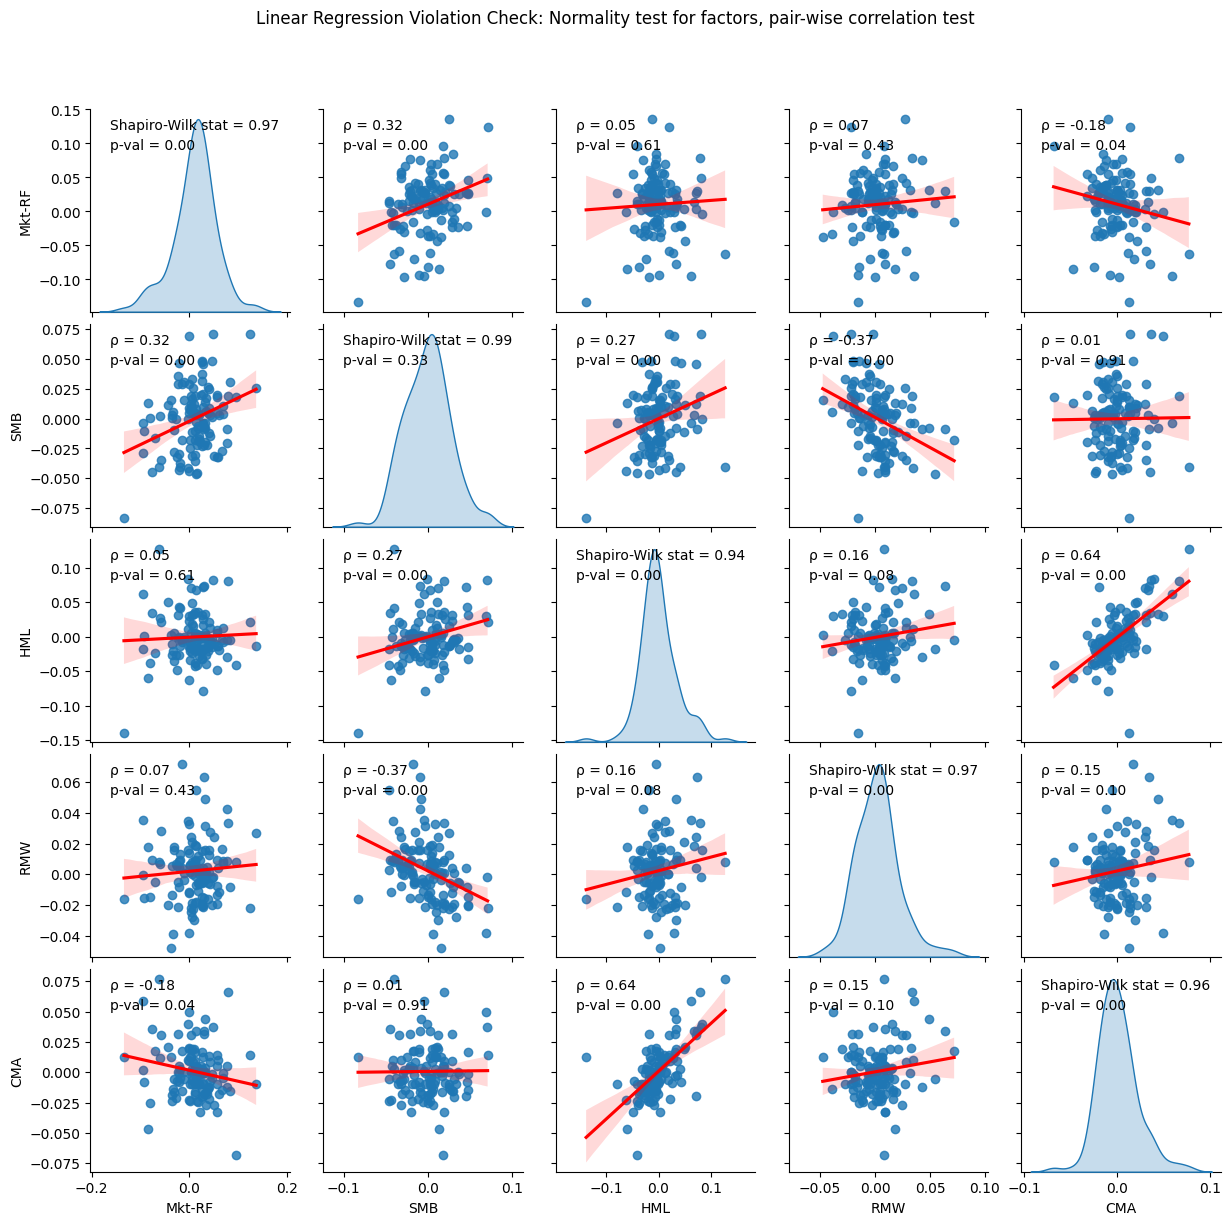

In [19]:
# Run EDA Functions on our dataset

# Generate pairplot
pp = sns.pairplot(df_ff_factors, kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

# Run the R2func for all off diagnonal cells, and normalityfunc for the diagonal ones...
pp.map_lower(R2func)
pp.map_upper(R2func)
pp.map_diag(normalityfunc)

# Title...
pp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

pp.fig.suptitle('Linear Regression Violation Check: Normality test for factors, pair-wise correlation test')

plt.show()


Eyeballing our data we can see from the frequency distributions on the diagonal, that all variables have approximately normally distributed. It can also be noted that HML and CMA are somewhat correlated, which may cause colinearity issues with the linear regression models we will use later.

# Stage3: Model Design

#### Bias Alert: Complexity Bias
There is a balancing act between model complexity and the data available, and if our model becomes too complex for the amount of data we will likely overfit to the data, and our model will not perform well out of sample. It will be a bad predictor. The more samples we have, and the more accurate the data, the more accurate our model will be. The more data we have the more features and model parameters  (ie complexity) we can employ to approximate our target function.

In practice, historic simulations require relatively large amounts of data to avoid overfitting. A relatively long history of returns is required to learn a linear regrssion model with many input variables[1], less for a classification model. ML models generally have more parameters than traditional linear models and therefore we need even more data for training. In short, we may not have high enough frequency data to train a stable model. This problem is exaccerbated when running simulations, as to avoid data snooping biases we can only use a subset of our full dataset that preceeds each simulation date.   

In [20]:
#***********************************************************************
#*** Complexity bias Sanity Check!***
#***********************************************************************
def bias_complexity_check_regression(no_of_instances: int,
                          no_of_features: int = 0,
                          no_of_parameters: int = 0) -> (bool, int, int):

  '''
  Check the complexity of the mode based on rules of thumb.

  Args:
    no_of_instances: Number of rows in your dataset
    no_of_features: Number of columns
    no_of_parameters: Number of weights/coefficients/parameters in your model

  Returns:
      rf: sklearn model object

  Author:
      failed: Did the complexity check fail? Too complex...
      feature_max: maximum number of features you shluld have given the problem type and instances
      param_max: maximum number of weights/coefficients/parameters in your model given the problem type and instances
  '''

  failed = False
  cb_K = no_of_features
  cb_n = no_of_instances

  # 1. Feature complexity: n ≥ 50 K
  if cb_n > 50 * cb_K:
    failed = True

  feature_max = int(round(cb_n / 50, 0))

  # 2. Parameter complexity: ¦θ¦ ≤ n/10
  #
  # The number of model parameters (ie weights) should observe the constraint
  # wrt training instances, n, features, K:
  #
  # |theta| >= n/10
  param_max = int(round(cb_n / 10, 0))

  if no_of_parameters > param_max:
    failed = True

  return (failed, feature_max, param_max)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## 3a. Traditional Quantitative approach: Linear Factors

We will test a simple, fundamental factor model applied to investing stocks in our universe, also known as a time-series factor model, after Fama and French. This has the form:
$$
R_{it} = α_{i} + \sum\limits_{j=1}^{K} \beta_{ij} f_{ij} + ϵ_{ij} \qquad \text{where}\; i=1,\dots, N\; j=1,\dots, K
$$
Where $R_{it}$ is the return of equity $i$ at time $t$, $\beta$ is the exposure (loading) of equity $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$.

In practice we will use a vectorized version of this factor model, which is much faster:

$$
R_{t} = \mathbf{α +β f_{t} + ϵ_{t}}
$$


We will first learn the loadings of each equity to each of the factors in the dataset, and we will then use these loadings and the assumed future factor returns to determine the expected return of each equity to form model portfolios.   


#### Bias Alert: Researcher bias

Biases that can arise due to the researcher being influenced in both data collection, data exploration and modelling approaches proposed by previous research. Factor investing, provides a number of possible areas for researcher bias, including model design and factors to use.

#### Bias Alert: Sample Distribution Bias

If the training data and the actual data to be predicted come from different distributions, this would likely challenge to the generalization ability of a model (ie how well it performs on future input data). If a parametric model is used, such as a linear factor model, the risks of shifting distributions are likely to be greater still, as normality assumptions may be violated, even if normlization/standardization of the input data is carried out.   

We now specify our model training process, using OLS regression. We will wrap this up as a function, so as we can call it multiple times to generate return simulations over the study term.

Note that we sanity check parameters, to provide basic checks, and we analyse the residuals produced by the model to ensure residuals are normally distributed (using a Shapiro-Wilk test in this case, with the option of generating a scatter plot in the function too).
Let us run the function, using our 5 factor regression on the first security in the dataset, column=0.

Many refinements can be made to this simple model.

### 3a. i) Prepare data

Our data is wrangled and ready but we need to shape it to pass it into our model to train and predict.



### 3a. ii) Equity Selection

As one function call we can train our model and predict our expected returns. Wrapped in this one function we train our model, passing in training data (in this case forming a training window of the past 36months), ensuring that this data is at or before our assumed execution date, and    

In [21]:
# Run the function with our data
df_all_er = LinearFactorInvesting.factormodel_forecast_all_er(df_benchmark_trades=None, # Only use df_benchmark_trades positions with a non NaN value
                                        df_tb3ms=df_tb3ms, # Risk free rate
                                        df_sec_rets=df_sec_rets, # security level returns histories, monthly in USD
                                        df_ff_factors=df_ff_factors, # factor returns monthly in USD
                                        window_size=36, # training window size
                                        factor_return_history=36) # prediction: return history of factors to assume will persist going forwards

# Test an example
test_this_equity = df_all_er.columns[0]
df_all_er.columns.get_loc(test_this_equity)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

0

#### Example: Expected Returns of a Single Equity
Let us train a factor model for on a single equity in the dataset using the past 36months of data, and then calculate this security's expected returns. We can also check the residuals of this model and check over the statistics. Note that the residuals do not appear entirely normal.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


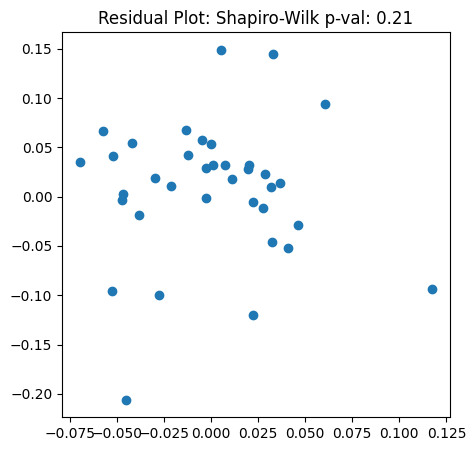

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     18.52
Date:                Thu, 07 Sep 2023   Prob (F-statistic):           2.25e-08
Time:                        09:58:11   Log-Likelihood:                 65.611
No. Observations:                  36   AIC:                            -119.2
Df Residuals:                      30   BIC:                            -109.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.008     -0.744      0.4

In [22]:

# Get an example equity
i = 0
t = 19 # Run the model as if we were at a timepoint 19months ago.

with warnings.catch_warnings(): # Supress warnings
    warnings.simplefilter("ignore")

    # Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
    ols_model, y, y_hat = LinearFactorInvesting.factormodel_train_single_security(sec_col_no=i,
                                                 df_tb3ms=df_tb3ms,
                                                 df_sec_rets=df_sec_rets,
                                                 df_ff_factors=df_ff_factors,
                                                 date_start=t+36,
                                                 date_end=t,
                                                 plot_residual_scatter=True)
    # Examine the fit, coefficients and OLS analytics.
    print(ols_model.summary())

    # Forecast E(R) for this security.
    df_equity_er = LinearFactorInvesting.factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_model.params, index=None),
                                    df_ff_factors=df_ff_factors,
                                    r_f=df_tb3ms.iloc[0,0],
                                    date_start=t+36,
                                    date_end=t,)

    print("Expected Return Forecast for this equity")
    print(df_equity_er)


### 3a. iii) Construct Model Portfolios

In each period we select the top quartile of our equity forecasts, and generate a DataFrame of equal weighted equities that reside in this quantile.
Next we assume a 6month rebalance frequency, and simulate the past returns of this portfolio over the study term

#### Bias Alert: Backtesting Bias

Back-testing bias includes forward-look (or data snooping) bias, where an analyst will check the performance of an approach over the past, and will tend to reject all approaches that perform poorly. In a sense the analyst becomes endogenous to the model, using a look-ahead to bias model selection to only those models that have worked well.

This issue can be addressed by testing only a small number of approaches (i.e., avoiding violation of independence assumptions) with strong investment rationales (i.e., causality) and/or by comparing the simulated returns to the possible empirical outcomes using target shuffling.

#### Bias Alert: Time-Interval/Forward Look Bias
When researcher selects a specific timeframe for training vs. validating vs. testing to support hypotheses and/or uses “restated” data not available during the time under study.

In [23]:
# Get the top 25% of equities by exepected return over the study term
df_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_all_er,
                                        rebalance_freq=6,
                                        min_quantile_to_buy=0.75)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

Top quantile generated


### 3a. iv) Simulate Returns
We can now conduct an historic simulation.  We iterate from the earliest time period where we have a model portfolio to the most recent period, generating expected returns for each equity in our model portfolio as we step forward through time, and simulating a rebalance event when there is a new model portfolio in a time period we step into.
We combine step ii) Forecast Equity Level Expected Returns, iii) Select Top Quartile Equities, and iv) Simulate Returns, into the next code block:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Analytics
Total Return (TR)(annualized)         -0.022265
Standard deviation (SD) (annualized)   0.317929
Sharpe Ratio (TR/SD)                  -0.070032
Hit rate (monthly)                     0.532468

Descriptive Stats
Mean (TR)               0.002300
Median (TR)             0.005235
Variance (TR)           0.008423
Skewness (TR)           0.068437
Kurtosis (TR)           1.502968

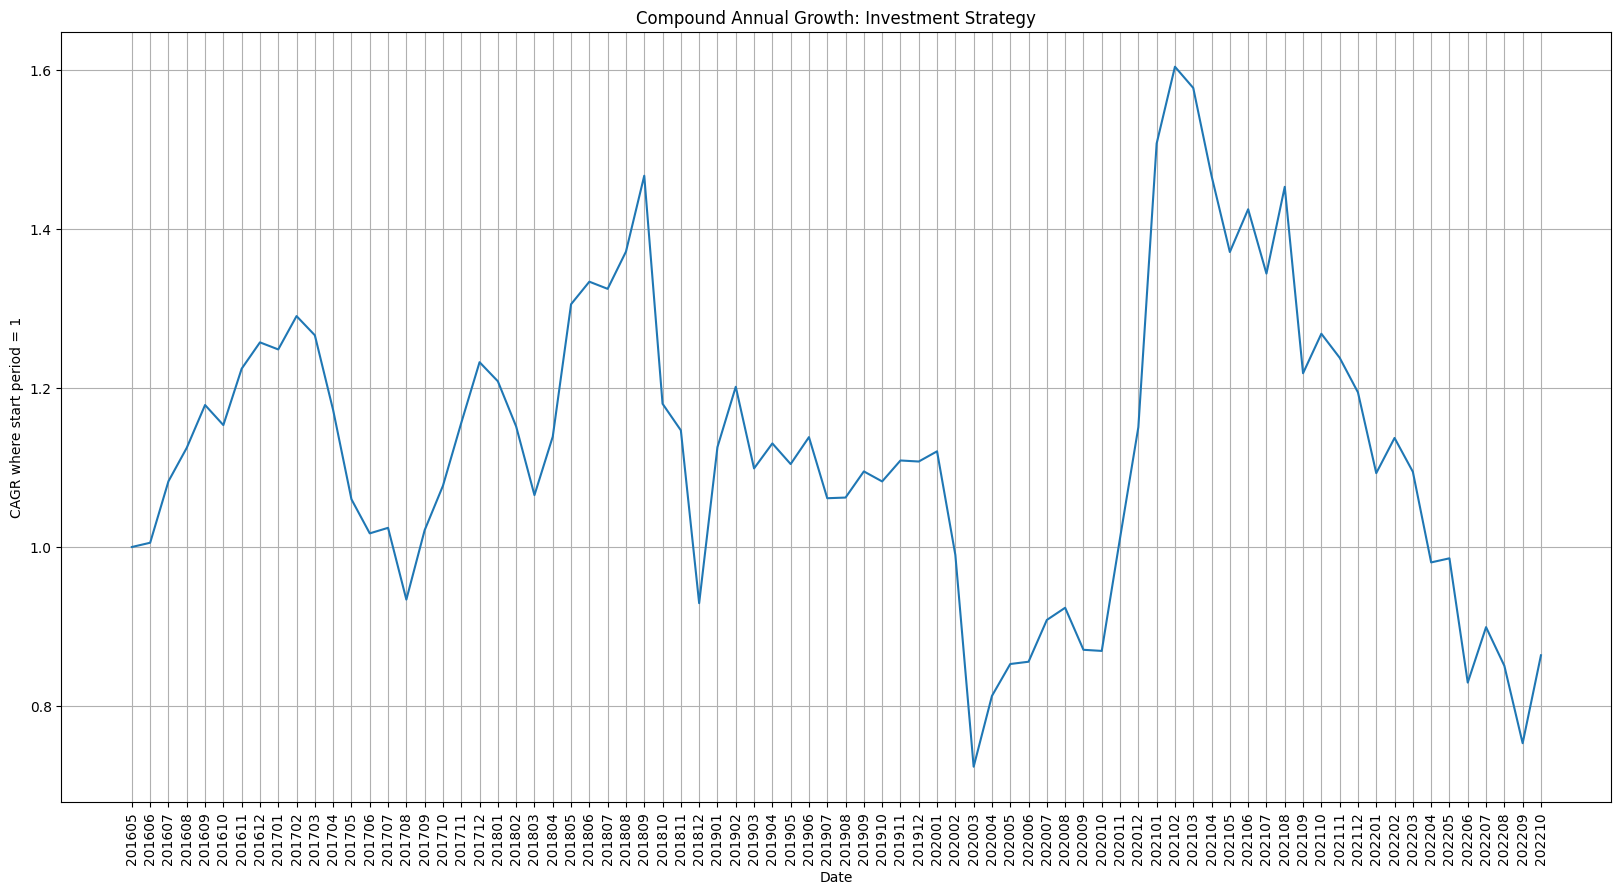

In [24]:


#====================================
# Run the Linear factor model
#====================================

# FF model
df_lin_all_er = LinearFactorInvesting.factormodel_forecast_all_er(df_benchmark_trades=None,
                                        df_tb3ms=df_tb3ms,
                                        df_sec_rets=df_sec_rets,
                                        df_ff_factors=df_ff_factors,
                                        window_size=36,
                                        winsorize_er=0)

# Run the function to establish simple positio sizes based
df_lin_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_lin_all_er,
                                        rebalance_freq=6,
                                        min_quantile_to_buy=0.75)

# Run the simulation function
df_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades,
                         rebalance_freq=6,
                         df_sec_rets=df_sec_rets,
                         date_start_of_sim=79)


Now we construct a simple benchmark from our universe...

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Analytics
Total Return (TR)(annualized)          0.022838
Standard deviation (SD) (annualized)   0.224034
Sharpe Ratio (TR/SD)                   0.101941
Hit rate (monthly)                     0.467532

Descriptive Stats
Mean (TR)               0.004021
Median (TR)            -0.003468
Variance (TR)           0.004183
Skewness (TR)          -0.389615
Kurtosis (TR)           2.337955

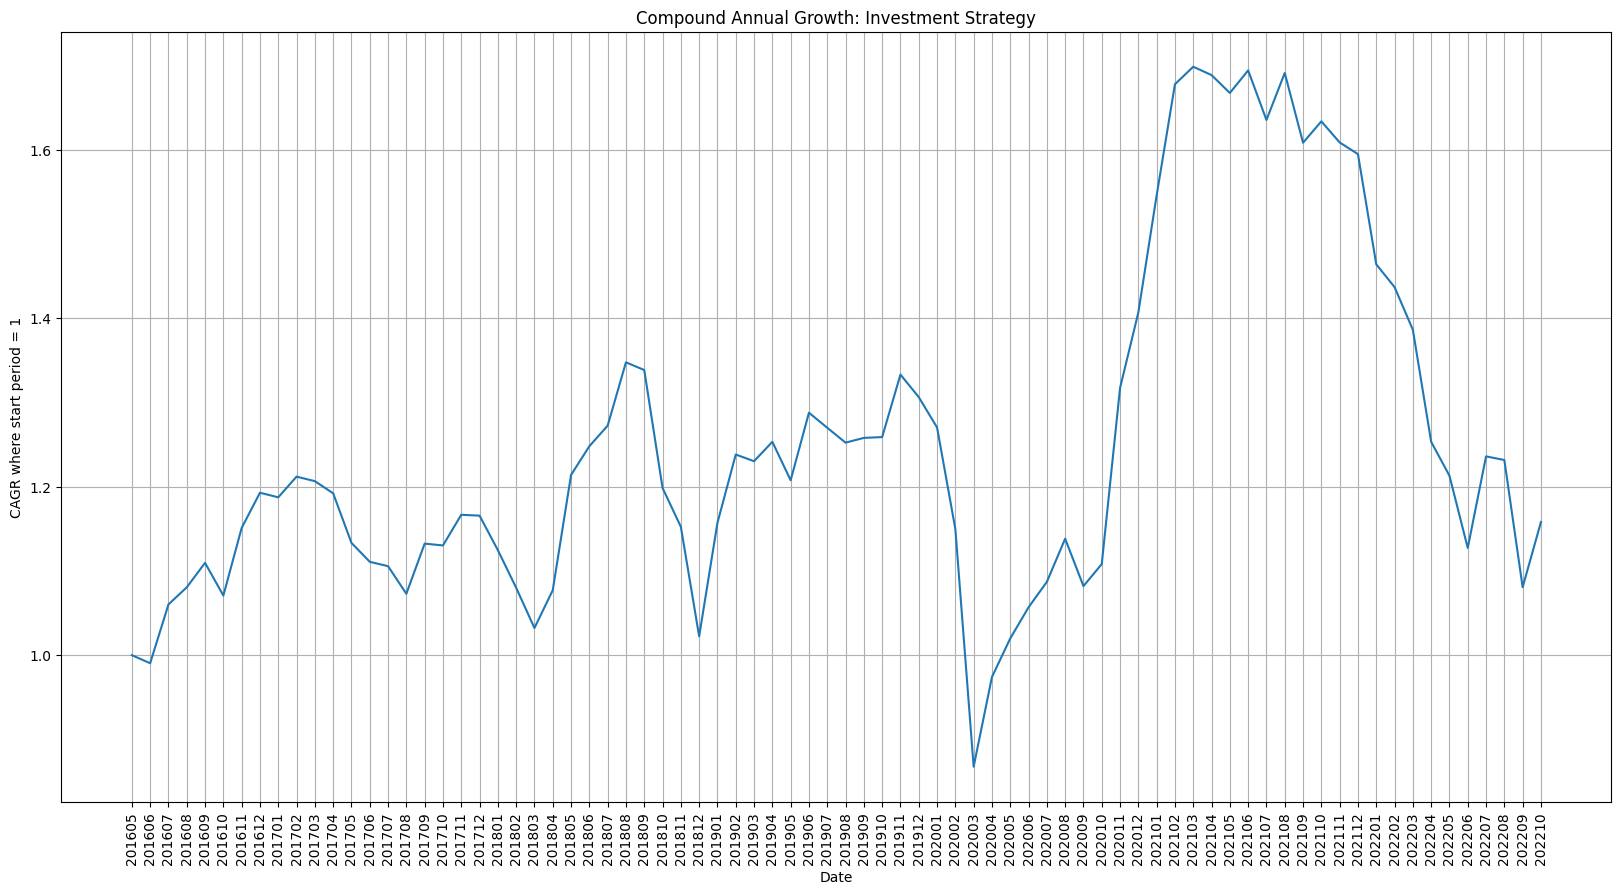

In [25]:
#====================================
# Create universe benchmark
#====================================
# Run the function to establish simple positions
df_benchmark_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_lin_all_er, rebalance_freq=6, min_quantile_to_buy=0)

df_sec_rets_copy = df_sec_rets.copy(deep=True)
df_sec_rets_copy[df_sec_rets_copy>5] = 5

# Create an equal weighted benchmark of all valid securities
# Run the simulation function
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades,
                                    rebalance_freq=6,
                                    df_sec_rets=df_sec_rets_copy,
                                    date_start_of_sim=79)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

Analytics
Total Return (TR)(annualized)         -0.022265
Standard deviation (SD) (annualized)   0.317929
Sharpe Ratio (TR/SD)                  -0.070032
Hit rate (monthly)                     0.532468

Descriptive Stats
Mean (TR)               0.002300
Median (TR)             0.005235
Variance (TR)           0.008423
Skewness (TR)           0.068437
Kurtosis (TR)           1.502968

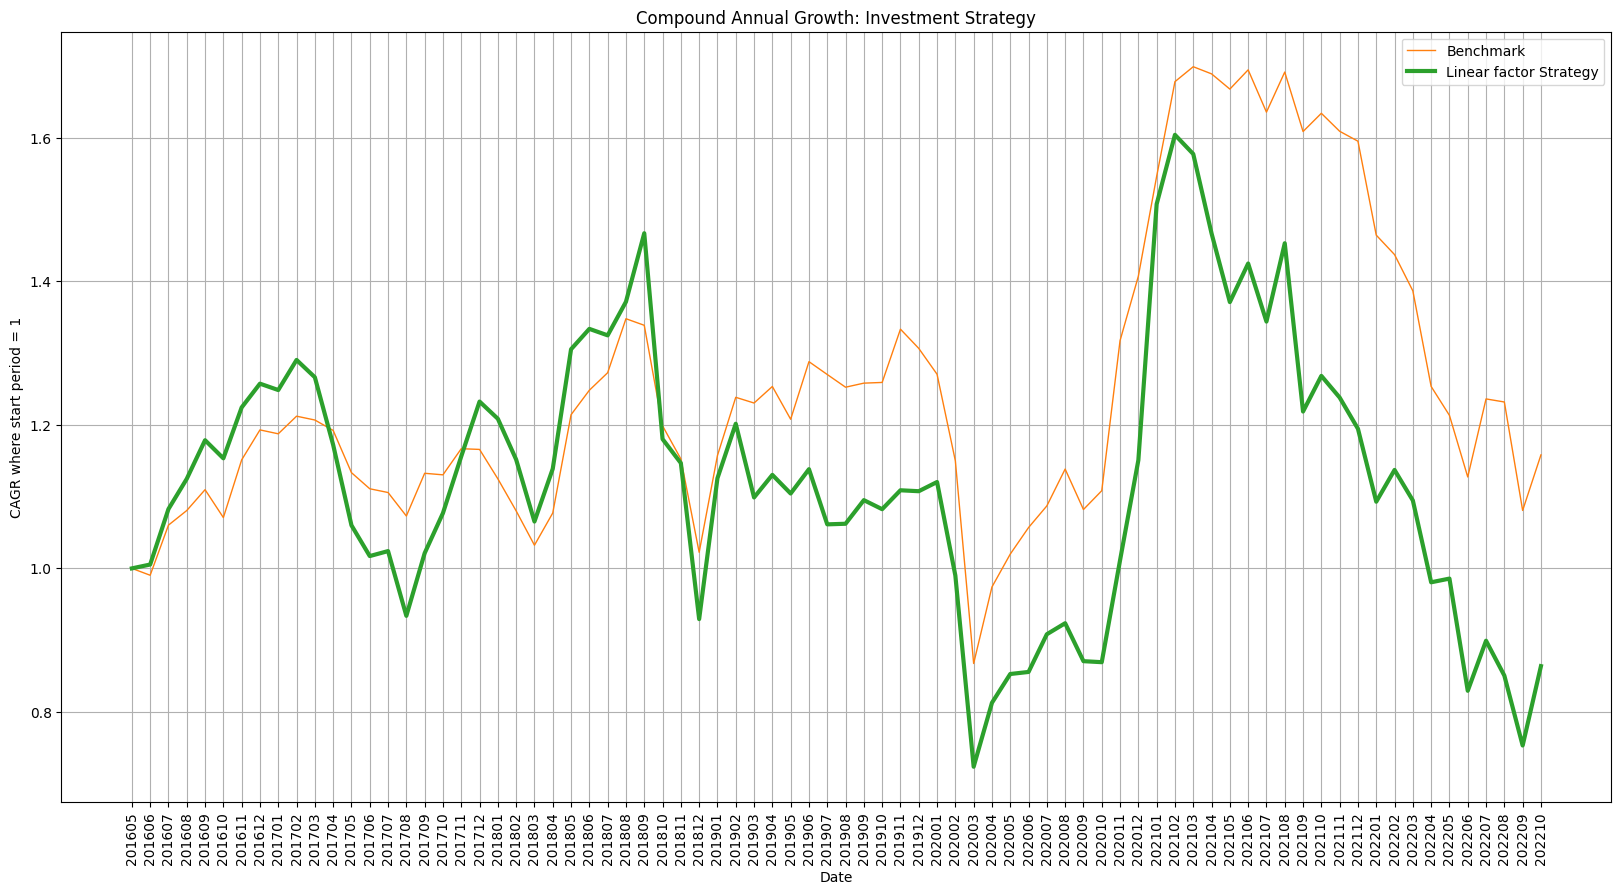

In [26]:
# Plot the linear-factor model CAGR vs the benchmark
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades,
                         rebalance_freq=6,
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=79)

# Chart
p = SimulationUtils.sim_chart(df_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy', emphasize=True)
p.legend()
p.show()

### 3a. v) Assess Returns

We can observe the total returns of our model and its performance against the benchmark but return simulations can give a misleading impression of how significant performance or risk adjusted returns would have been. As we saw in previous modules, we can construct an empirical distribution of possible returns using "target shuffling". This allows us to look at many of the combinations of securities we could have held over the study term which allows us to compare our results to the results of these randomly selected portfolios.  

In [27]:
# get an empirical distribution of outcomes using target-shuffling "lite"
dt_target_shuffling_dist = RobustInvestmentUtils._target_shuffling_lite_get_dist(df_opportunity_set_trades=df_benchmark_trades, # Randomly allocate to equities ino our universe
                                      min_quantile_to_buy = 0.75, # Same rebalance assumptions as our approach
                                      df_sec_rets=df_sec_rets,
                                      rebalance_freq=6, # Same rebalance assumptions as our approach
                                      iterations=100) # Number of portfolios to randomly create and simulate

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## **Factor Model Results**

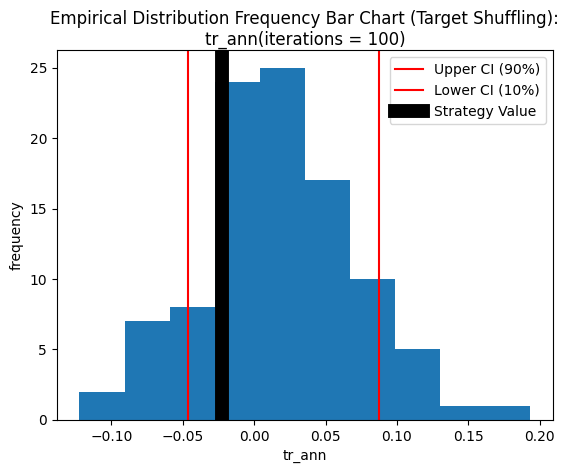

Empirical probability value of the strategy: tr_ann:0.8


## **Benchmark Results**

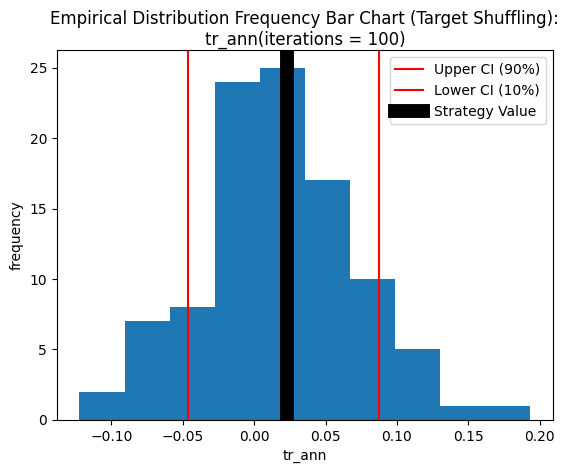

Empirical probability value of the strategy: tr_ann:0.47


In [28]:
# check the performance of the using target shuffling lite, to form an empirical distributon of returns
display(Markdown('## **Factor Model Results**'))
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_lin_sec_cagr)
# benchmark
display(Markdown('## **Benchmark Results**'))
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

We can conclude that factor models would have done a poor job of adding value over the benchmark over this period of time, which may cause us to decide to reject this approach.

#### Bias Alert: Certainty bias

Significance tests do not by themselves provide a logically sound basis for concluding an effect is present or absent with certainty or a given probability. A broader analysis than just the hypothesis and the analyzed data (which give only statistical probabilities) must be used to reach such a conclusion.

#### Bias Alert: Endogenous bias
Endogeneity bias is not a simple violation and there is no easy statistical solution. It has serious consequences for outcomes, where in the presence of endogenous variables OLS learns biased and inconsistent parameters. P-values can be seriously misleading. All it takes is one endogenous variable to seriously distort ALL OLS parameters.

One potentially concerning endogeneity is self-fulfilling prophecy of factor investing, where equities with high correlations to commonly used factors would cause investments in those equities, causing price appreciation, affirming that the correlations with those factors caused the price rises.


## 3b. Factor Approach with Non-linear Regression

We now examine applying machine learning to a traditional quantative framework. Rather than linearly multiplying the expected returns of factors and stock level factor loadings as a simple linear factor approach does, we now train an MLP neural net to forecast expected returns based on stock level factor loadings and past factor returns.

$$
R_{it} = \tilde{f}(\beta_{i,1}, ... , \beta_{i,K}, f_{1}, ..., f_{K})
$$

The MLP we will use has the following architecture, where the 11 input units relate to our 6, equity level factor coefficients (ie 5 $β$s, one $α$), and 5 corresponding factor returns over the longer run $\tilde{f}$. The architecture is shown with on hidden-layer, of 3 hidden units, and one output $R$.

<div>
<img src="attachment:image-3.png" width="500"/>
</div>

### 3b. i) Prepare data

We still need to calculate factor loadings at the stock level as before, but we now need to pass training data to our MLP. See the X (stock level factor loadings, assumed factor returns) and y variable (future return) we will be using below

In [29]:
# Show the training data shape to traing the MLP
X_nlf_train, y_nlf_train = NonLinearFactorInvesting.nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                               df_sec_rets=df_sec_rets,
                               df_ff_factors=df_ff_factors,
                               date_end=0,
                               func_training_period = 1)

print('X consists of stock level factor loadings, and assumed futuure factor returns')
display(X_nlf_train)
print('y consists of the stock level returns we want to forecast')
display(y_nlf_train)

X consists of stock level factor loadings, and assumed futuure factor returns


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


const_coef  Mkt-RF_coef  SMB_coef  HML_coef  RMW_coef  CMA_coef  \
ZTR-US     -0.005556     1.063410 -0.127381  0.471523 -0.165179  0.061840   
WMK-US      0.008444     0.164470  0.753776 -0.827601  1.122391  0.925210   
VPG-US     -0.021032     1.259646  0.760806 -0.165068  0.274165  0.709805   
VHI-US     -0.009203     0.916943  0.854201  0.134208  1.889866  0.295648   
VCYT-US    -0.004166     1.806619  0.164320 -0.765697 -2.123445  0.927208   
...              ...          ...       ...       ...       ...       ...   
ARNGF-US   -0.000913     1.530106 -0.360569 -0.239072  1.032844 -0.376222   
ALT-US      0.121564     0.207094  1.030194 -0.193942 -0.985813 -5.394008   
ALJJ-US     0.009708     1.157690  1.207443  0.197822  1.051588  0.415108   
AJRD-US     0.001204     0.598605  0.743336 -0.775104 -0.011455  0.969888   
AGTC-US    -0.009609     0.499991  0.254067  1.709696 -0.386958 -2.687226   

          Mkt-RF_ret  SMB_ret   HML_ret   RMW_ret   CMA_ret  
ZTR-US      0.094024  0.02194  0.028276  0.067499  0.065668  
WMK-US      0.094024  0.02194  0.028276  0.067499  0.065668  
VPG-US      0.094024  0.02194  0.028276  0.067499  0.065668  
VHI-US      0.094024  0.02194  0.028276  0.067499  0.065668  
VCYT-US     0.094024  0.02194  0.028276  0.067499  0.065668  
...              ...      ...       ...       ...       ...  
ARNGF-US    0.094024  0.02194  0.028276  0.067499  0.065668  
ALT-US      0.094024  0.02194  0.028276  0.067499  0.065668  
ALJJ-US     0.094024  0.02194  0.028276  0.067499  0.065668  
AJRD-US     0.094024  0.02194  0.028276  0.067499  0.065668  
AGTC-US     0.094024  0.02194  0.028276  0.067499  0.065668  

[77 rows x 11 columns]

y consists of the stock level returns we want to forecast


ALL
ZTR-US   -0.079535
WMK-US    0.369699
VPG-US   -0.008047
VHI-US    0.081729
VCYT-US  -0.047698
...            ...
ARNGF-US -0.445008
ALT-US    0.862917
ALJJ-US   0.135603
AJRD-US   0.069173
AGTC-US  -0.485985

[77 rows x 1 columns]

### 3b. ii) Equity Selection

Now we need functions to generate factor loadings at the stock level, then to train our neural net, and to provide the final forecast of equity returns in a given time period. We will need these function to generate expected returns.

#### Example: Expected Returns at a Single Time Point
We can test our model, training it at a specific time point to observe the residuals of our model.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
p-value may not be accurate for N > 5000.


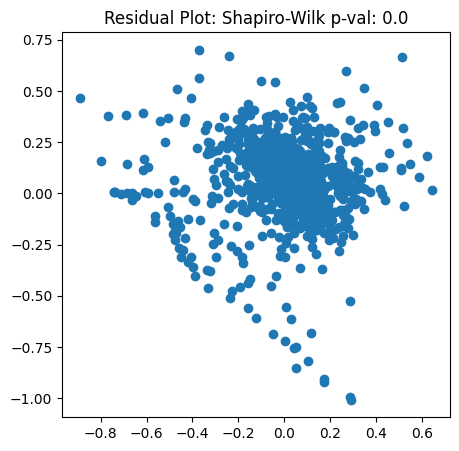

R2: 0.45; F-stat: 68.17


In [30]:
# train nn
nn_model, X_nlf, y_train_nlf, y_hat_nlf = NonLinearFactorInvesting.nonlinfactor_train_er_func(df_tb3ms=df_tb3ms,
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              forecast_ahead=6,
                                              window_size=36,
                                              func_training_period=12,
                                              plot_residual_scatter=True)


Now we can implement a function that applies the forecasting function over the study term, ready for historic simulation testing.

In [31]:

# Run the function with our data
df_nlf_all_er, nn_mod_latest = NonLinearFactorInvesting.nonlinfactor_forecast_all_er(df_benchmark_trades=None, # which equities to include?
                                                            df_tb3ms=df_tb3ms,
                                                            df_sec_rets=df_sec_rets,
                                                            df_ff_factors=df_ff_factors, # factor return data
                                                            window_size=36, # period to calculate equity loadings over
                                                            func_training_period=1) # how many periods should we stack up to train the MLP

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

### Bias Alert: Complexity Bias
Using a complex model such as a neural net may be appealing but number of parameters the model needs to have trained may exceed our rule of thumb for complexity. It may in anycase, not an ideal learner to apply, if a more simple approach achieves a similar result.


In [32]:
# count the number of parameters in the MLP
param_count = 0
for i in range(0, nn_model.coefs_.__len__()):
  param_count += nn_model.coefs_[i].shape[0]


# Sanity Check: Biases ************************
failed, _, _ = RobustInvestmentUtils.bias_complexity_check_regression(no_of_instances=36, # Try to use  36month window to train the MLP
                                    no_of_features=X_nlf.shape[1]-1, # Do not count intercept
                                    no_of_parameters=param_count)
if failed == True:
  print("************ Complexity bias warning ***************")
# Sanity Check: Biases ************************

************ Complexity bias warning ***************


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### 3b. iii) Construct Model Portfolios,  iv) Simulate Returns

Again, based on expected returns from the model, we construct model portfolios over the study term, and then run our historic simulation. We will also chart the returns of our benchmark and other simulation returns as a comparator.

Note that the returns from the Non-Linear Factor approach will vary slightly each time they are run, owing to the stochastic nature of the neural net training.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


Analytics
Total Return (TR)(annualized)          0.096016
Standard deviation (SD) (annualized)   0.269336
Sharpe Ratio (TR/SD)                   0.356492
Hit rate (monthly)                     0.597403

Descriptive Stats
Mean (TR)               0.010792
Median (TR)             0.014162
Variance (TR)           0.006045
Skewness (TR)          -0.205502
Kurtosis (TR)           1.781019

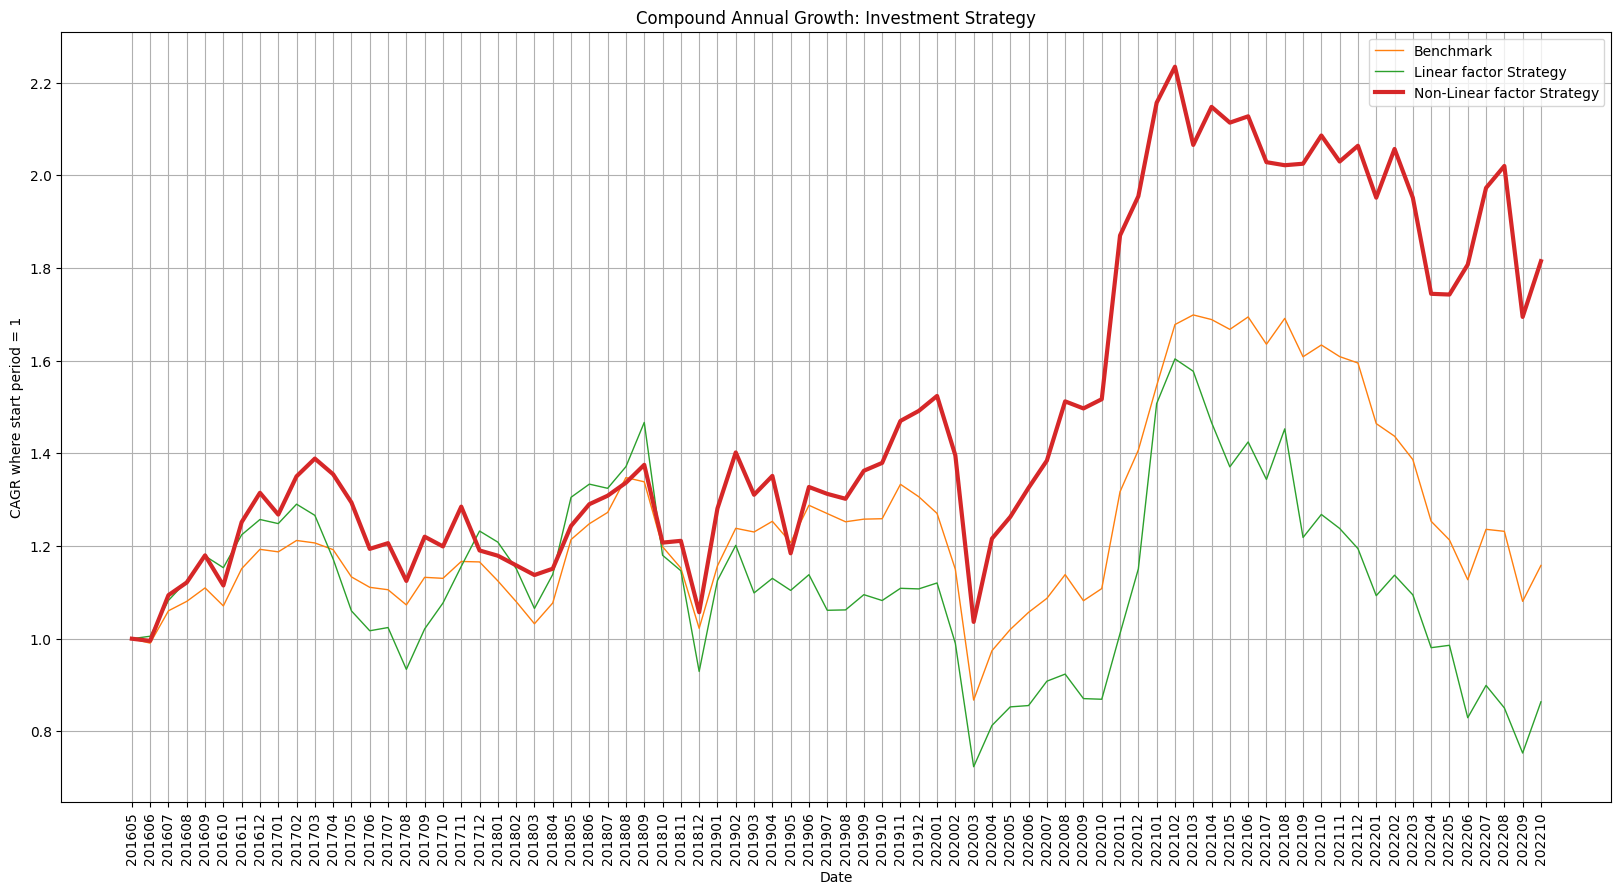

In [33]:
# Run the function to establish simple trades
df_nlf_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_nlf_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades,
                         rebalance_freq=6,
                         df_sec_rets=df_sec_rets,
                         print_chart=False)

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy', emphasize=True)
p.legend()
p.show()

### 3b. v) Assess Returns

First we need to understand how the NonLinear Factor Model is driving its returns, but we are using a black-box model which makes this difficult. To address this we use the SHAP explainable AI (XAI) package to examine how the input data is driving outputs of the model, using parameter importance.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


  0%|          | 0/25 [00:00<?, ?it/s]

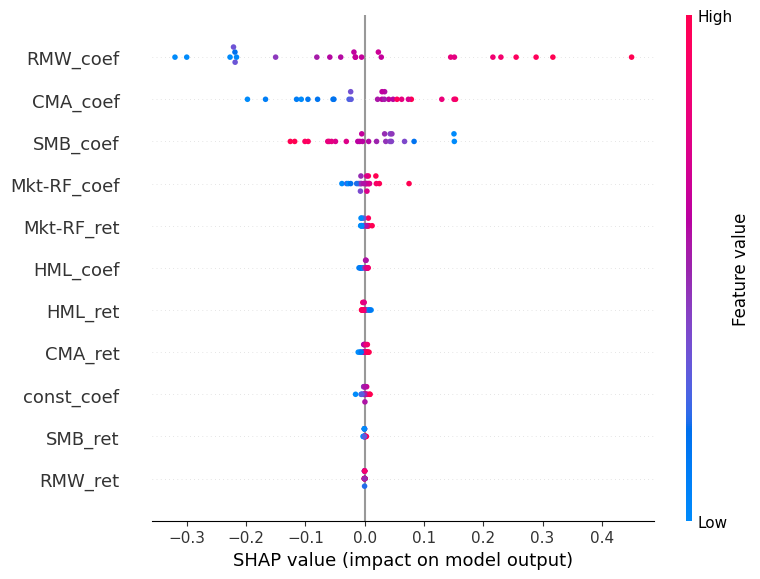

In [34]:
import shap

# This can take a while
# SHAP XAI on the training data
samples_to_use = 25
X_nlf_sample = shap.sample(X_nlf, samples_to_use)
explainer = shap.KernelExplainer(nn_model.predict, X_nlf_sample)

with warnings.catch_warnings(): # Supress warnings
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(shap.sample(X_nlf, samples_to_use))
    shap.summary_plot(shap_values, X_nlf_sample.values, feature_names=X_nlf_sample.columns)

Now we examine whether the returns are unusually good (or bad) using the target shuffling lite approach. From the chart below we can see the model's performance versus the target shuffling distribution (vertical back line).

**Note that this result will vary on each run of this notebook, as the train/test dataset splitting and the MLP training both have randomized elements.**

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## **Non-linear Factor Model**

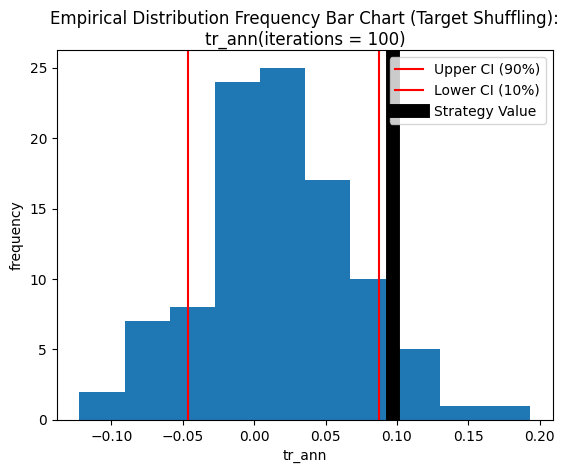

Empirical probability value of the strategy: tr_ann:0.07


In [35]:
# check the performance of the using target shuffling lite, to form an empirical distributon of returns
display(Markdown('## **Non-linear Factor Model**'))
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_non_lin_sec_cagr)

## 3c. Interpretable Machine Learning Approach


An alternative to enhancing traditional quant investing with ML is to use a purpose designed ML approach. We will use Symbolic artificial intelligence (SAI) [1], an investment rules-learning ML approach which aims to avoid many of the biases in traditional quantitative investing, and potential biases in combining traditional quantitative investing with ML. We will test a simplified SAI approach now.

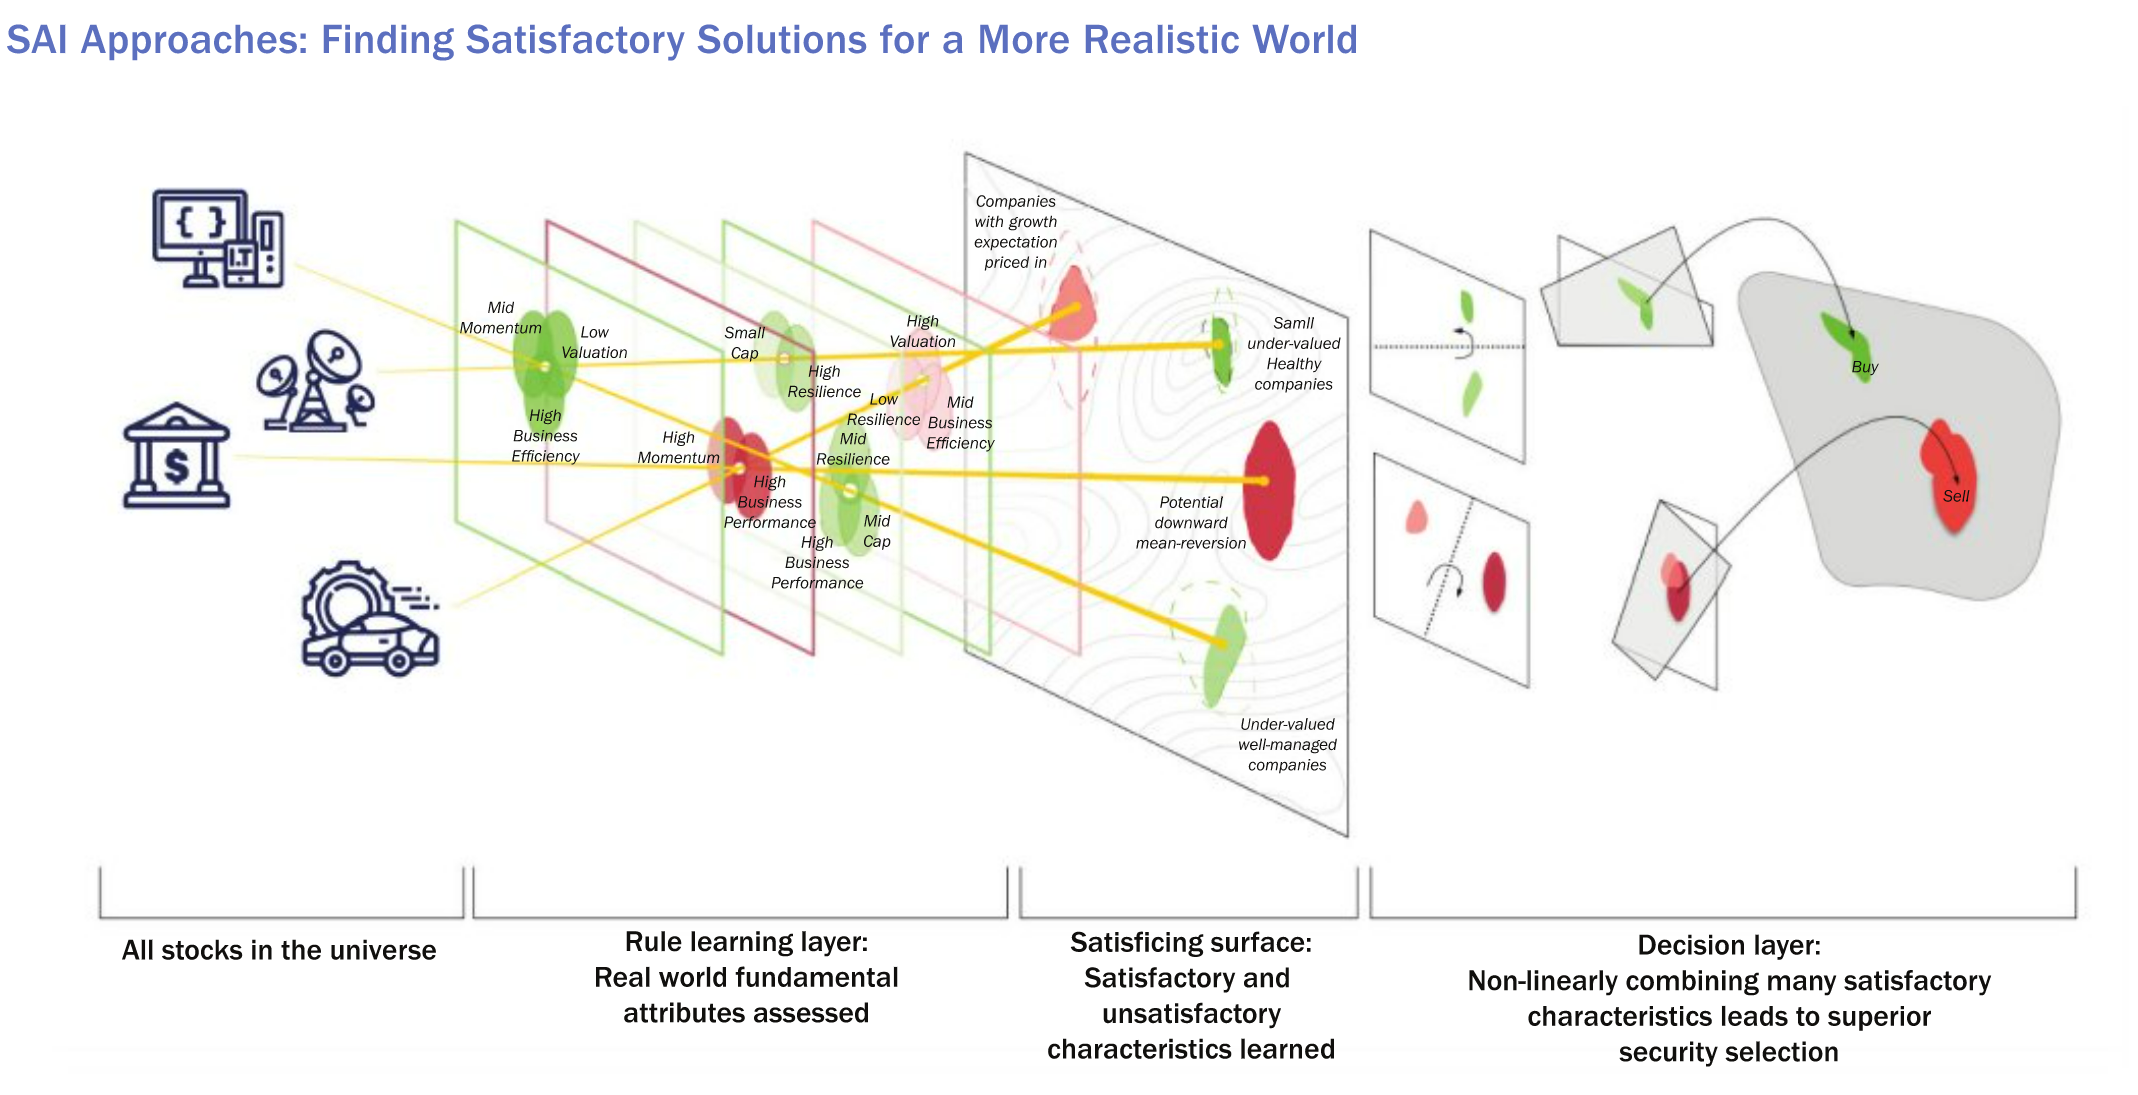

Import the SAI package...

In [36]:
from investsai.sai import SAI

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### 3c. i) Prepare Data
We will use the same factor loadings data we used previously, except SAI can be trained on factor loadings fom many time periods (we use 3 below: func_training_period=3). Our ground truth is stocks that generate a total return in the top 25% of the universe in 6months time (forecast_ahead=6).

In [37]:
# Get training and test data to pass into SAI
sai_X, sai_y_class, sai_y_tr = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms,
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=None, #<< Pass populated dict None,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.333,
                                  forecast_ahead=6, # << Forecasting 6months ahead
                                  window_size=36, # << Calculate factor loadings over this period
                                  func_training_period=6) ## << Use this many periods to train SAI
sai_X

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


const    mkt-rf       smb       hml       rmw       cma
ticker                                                                
ZTR-US_6   -0.005556  1.063410 -0.127381  0.471523 -0.165179  0.061840
ZF-US_6     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
XRM-US_6    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
XOXO-US_6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
WMK-US_6    0.008444  0.164470  0.753776 -0.827601  1.122391  0.925210
...              ...       ...       ...       ...       ...       ...
ARCW-US_11 -0.012454  0.776972  3.748564 -2.234895  3.109533  2.856547
ALT-US_11   0.073197  0.917132  2.181257 -1.383623 -0.818438 -5.010402
ALJJ-US_11 -0.013627  0.892841  2.186617 -0.110813  1.736496 -2.126971
AJRD-US_11  0.004736  0.724273  0.047299 -0.352002 -0.923879  1.048348
AGTC-US_11 -0.018994  1.557143 -0.004157  1.002954 -0.896808 -1.277738

[666 rows x 6 columns]

Note: In the SAI training data above we have stacked factor loadings for all the equities in our universe for periods 6, 7, and 8 (note the "_6" suffix for the security tickers for data from period 6 for example). As we specified a "date_end=0", but a "forecast_ahead=6" SAI will use data from 6 periods ago to train the model with a y-variable from "date_end=0". This it to avoid data-snooping. We have 3 periods in the training data (6,7,8) owing to "func_training_period=3".

### 3c. ii) Forecast Equity Level Expected Returns


In [38]:
# Train our SAI model (factor loadings data only)
sai_mod, sai_X, sai_y, sai_y_hat = SAIInvesting.sai_train_er_func(df_tb3ms=df_tb3ms,
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=None,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0, #<< Training a model at the latest date
                                  buysell_threshold_quantile=0.333, #<< Predict stocks in the top 25% of return outcomes
                                  lift_cut_off=1.0, #<< Only learn rules where the lift >125%
                                  forecast_ahead=6, #<< predict stocks returns in 6monmths time.
                                  window_size=36, #<< Factor loadings calculated over 36months
                                  func_training_period=12, #<< SAI training data will use 12x months of stacked loadings for the equity universe
                                  show_analytics=True)
sai_X[sai_X==0] = np.nan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



...................................
   training Invest-SAI algorithm   
...................................


....................................
            predicting             
...................................



We can review the investment rules SAI has learned, where the first rule (mkt-rf_3, cma_3) indicate equities need to satisfy "mkt-rf_3" and "rmw_3": which means a market beta in the top third (tercile) ("_3" is the top, "_1" is the bottom tercile) combined with an RMW loading in the top third of the equity universe.

In [39]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_mod.rules[(sai_mod.rules['causal_lift']>1.0)].reset_index(drop=True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


rules  cond_success_prob  odd_ratio  causal_lift  \
0                  (const_2)           0.521212   1.007770     1.003258   
1          (mkt-rf_3, rmw_3)           0.695035   2.290580     1.337843   
2             (smb_2, hml_3)           0.620000   1.587998     1.193410   
3          (smb_2, mkt-rf_3)           0.596899   1.415760     1.148945   
4    (const_1, smb_3, rmw_3)           0.732394   2.802005     1.409753   
..                       ...                ...        ...          ...   
93  (mkt-rf_2, hml_1, smb_3)           0.717172   2.498965     1.380452   
94  (hml_1, rmw_1, mkt-rf_3)           0.770115   3.323200     1.482360   
95            (hml_1, rmw_1)           0.772727   3.589878     1.487388   
96   (const_3, hml_1, smb_3)           0.793103   3.827180     1.526610   
97     (hml_1, rmw_1, smb_3)           0.777778   3.488746     1.497110   

     returns  
0  -0.005522  
1  -0.006872  
2  -0.008753  
3  -0.009871  
4  -0.010995  
..       ...  
93 -0.113909  
94 -0.114411  
95 -0.117200  
96 -0.124581  
97 -0.144699  

[98 rows x 5 columns]

We can now apply this same process across the full study term, generating rules in each period to drive expected return forecasts in each.

In [40]:
# Run the function with our factor loadings data
df_sai_all_er, sai_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms,
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=None,
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.333, #<< FLag the top and bottom stocks to make rules for
                                                    lift_cut_off=1.0, #<< Only learn rules where the lift > ...
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=6,
                                                    plot_residual_analytics=False) # << Make True to show the rules in every time period in the term


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

### 3c. iii) Construct Model Portfolios, iv) Simulate Returns



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


Analytics
Total Return (TR)(annualized)          0.066045
Standard deviation (SD) (annualized)   0.238811
Sharpe Ratio (TR/SD)                   0.276557
Hit rate (monthly)                     0.563380

Descriptive Stats
Mean (TR)               0.007772
Median (TR)             0.011166
Variance (TR)           0.004753
Skewness (TR)          -0.035410
Kurtosis (TR)           1.986018

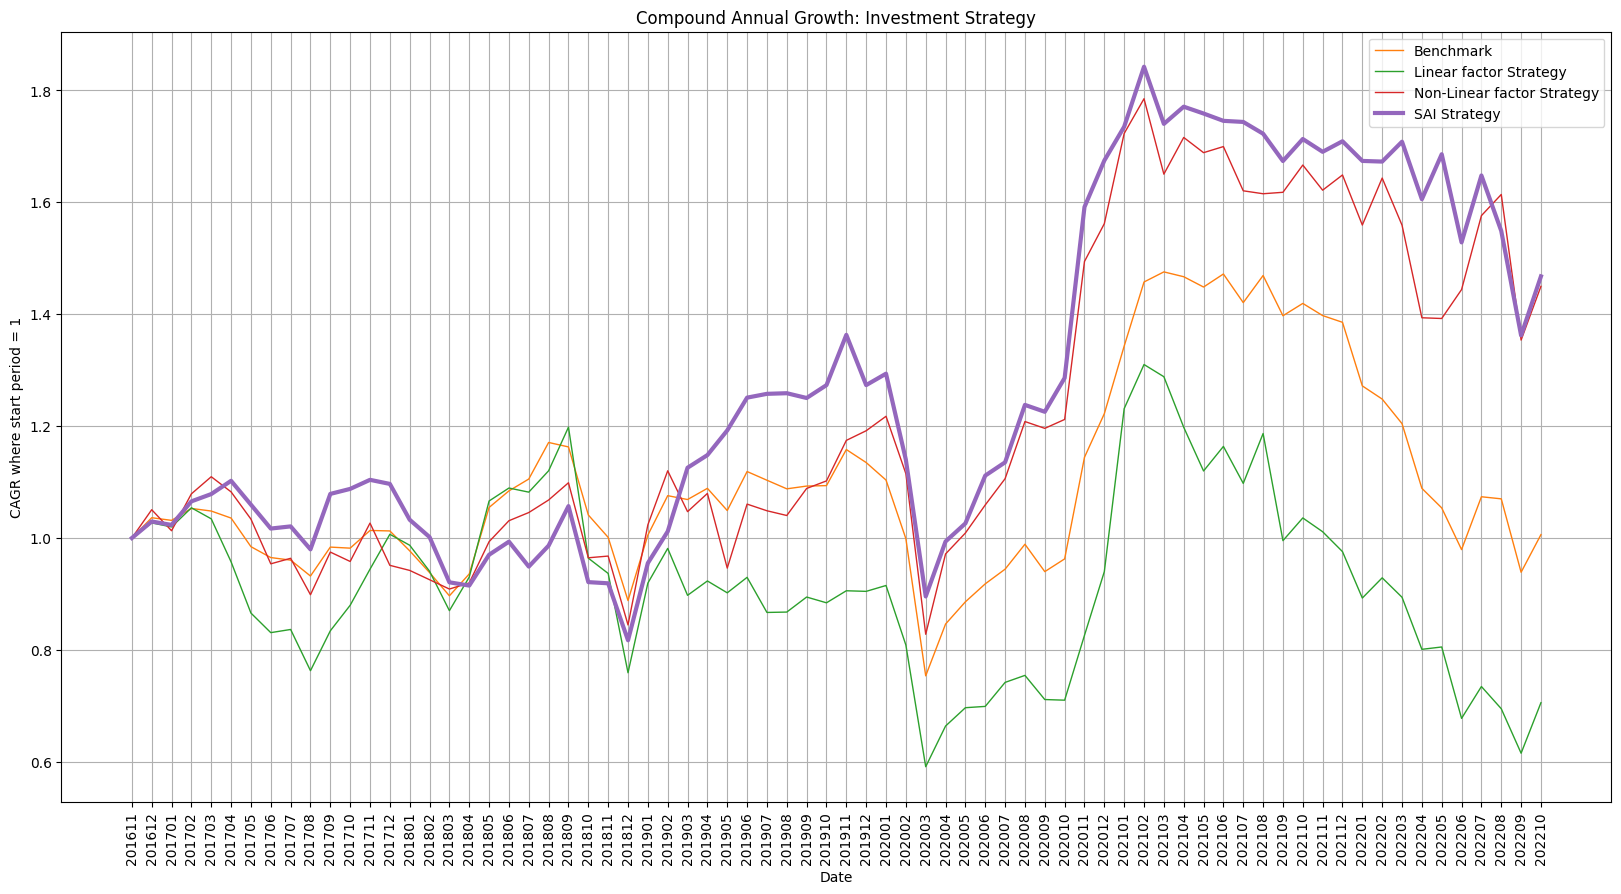

In [41]:
# Run the function to establish simple trades
df_sai_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_er,
                                                            rebalance_freq=6,
                                                            min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades,
                         rebalance_freq=6,
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=start_date)

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_sai_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy', emphasize=True)
p.legend()
p.show()

### 3c. iv) Assess Returns
We now compare our model performance vs the empirical distribution generated by the target shuffling lite approach.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## **SAI Model Results**

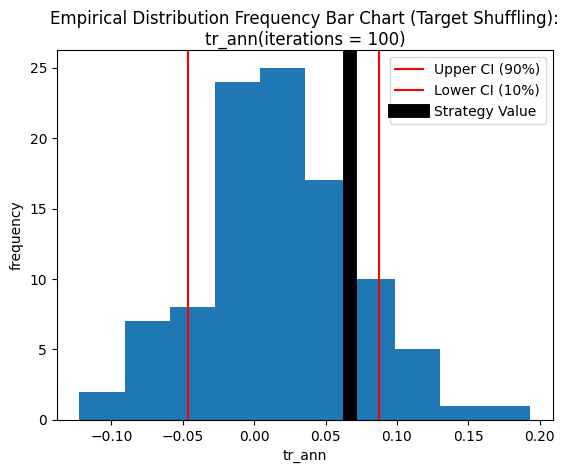

Empirical probability value of the strategy: tr_ann:0.17


In [42]:
# check the performance of the SAI simulation using target shuffling lite, to form an empirical distributon of returns
display(Markdown('## **SAI Model Results**'))
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_sai_sec_cagr)

## Bias Alert: End point bias

End point bias refers to the biased selection of a given time period and end date we might use to assess a model's performance. It is notable that each approach we have tested has certain periods where it appears to be the "best", and assessing performance to the last elapsed period is to some extent aritrary. We can deal with this to some extent by using different sub-time periods to assess model performance over, perhaps coinciding with different market conditions (analytics such as hit rate can also allow us to assess consistency of return delivery). We can also test our model out-of-sample, and in subsamples, such as in different countries and sectors to assess generalization.

## 3d. SAI Using Fundamental Data and Increasing Lift

Having compared the SAI output to linear and non linear factor models, we can now train the SAI model on more than just the factor loadings, adding our unaltered fundamental data to the training also. We can also increase the lift our rules need to achieve to be used to 2.

In [43]:
# Get training and test data to pass into SAI
sai_X, sai_y_class, sai_y_tr = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms,
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff, #<< Pass populated dict of raw fundamentals/valuations/ratios
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.333,
                                  forecast_ahead=24,
                                  window_size=36,
                                  func_training_period=6)

display(sai_X)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


const    mkt-rf       smb       hml       rmw       cma  \
ticker                                                                    
WMK-US_24    0.005119  0.050981  1.471667 -0.950796  0.188271  1.597215   
VRTU-US_24   0.023082  0.829798  0.040387  1.523790 -0.664803 -2.679792   
VPG-US_24    0.003146  1.114783  0.990664  0.426800 -0.526570 -1.108589   
VHI-US_24    0.003783  1.056513  1.567002  0.992615  1.613003  0.342705   
VCYT-US_24   0.056268  1.241852 -0.316916  0.011767 -4.180452  2.409691   
...               ...       ...       ...       ...       ...       ...   
BKE-US_28    0.028171  0.475138  2.115554  0.716516  1.099838 -0.115410   
BANC-US_28  -0.001137  1.152556  1.746731  0.920719  0.408440 -0.960276   
AXDX-US_28  -0.026360  2.623788  2.473787 -2.333830  3.019430  3.801471   
AVK-US_28   -0.001350  1.067192  0.292537  0.278127 -0.217759 -0.244881   
ARNGF-US_28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             ff_net_mgn      ff_roe    ff_rotc    ff_pbk    ff_pcf  
ticker                                                              
WMK-US_24      1.918636    6.531664   7.358595  1.019290       NaN  
VRTU-US_24     3.652194    9.554584   8.029232  2.153210       NaN  
VPG-US_24      7.813832    9.651677  11.840111  1.904950       NaN  
VHI-US_24      2.592885    7.715227   7.816937       NaN       NaN  
VCYT-US_24   -10.467068   -7.893863  -8.448502  5.786220       NaN  
...                 ...         ...        ...       ...       ...  
BKE-US_28     11.599948   26.673222  22.660625  3.086510   9.11893  
BANC-US_28     5.757852    2.512550   1.464784  1.218680  11.53510  
AXDX-US_28  -906.797892 -337.246980 -47.892761       NaN       NaN  
AVK-US_28    150.641128    9.481144   5.617260  0.905131  23.96560  
ARNGF-US_28  -34.621492  -16.332775   0.320948  0.508403   3.63554  

[221 rows x 11 columns]

Note that we now have extra columns of data such as ff_net_mgn (net margin), ff_oper_mgn (operating margin), ff_roa (return on assets), ff_roe (return on equity), ff_rotc (return on total capital), ff_tcap (total capital), and ff_pbk (price to book). These were chosen arbitrarily and more columns of data can be added as appropriate.

In [44]:
# Run the function with our factor loadings data
df_sai_all_features_all_er, sai_all_features_mod = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms,
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=dict_sec_ff,
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=-0.333, #<< FLag the top and bottom stocks to make rules for
                                                    lift_cut_off=2.0, #<< Only learn rules where the lift >2 ...
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=6,
                                                    plot_residual_analytics=False)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


Analytics
Total Return (TR)(annualized)          0.073677
Standard deviation (SD) (annualized)   0.410497
Sharpe Ratio (TR/SD)                   0.179482
Hit rate (monthly)                     0.478873

Descriptive Stats
Mean (TR)               0.012770
Median (TR)            -0.000664
Variance (TR)           0.014042
Skewness (TR)           0.466988
Kurtosis (TR)           1.197437

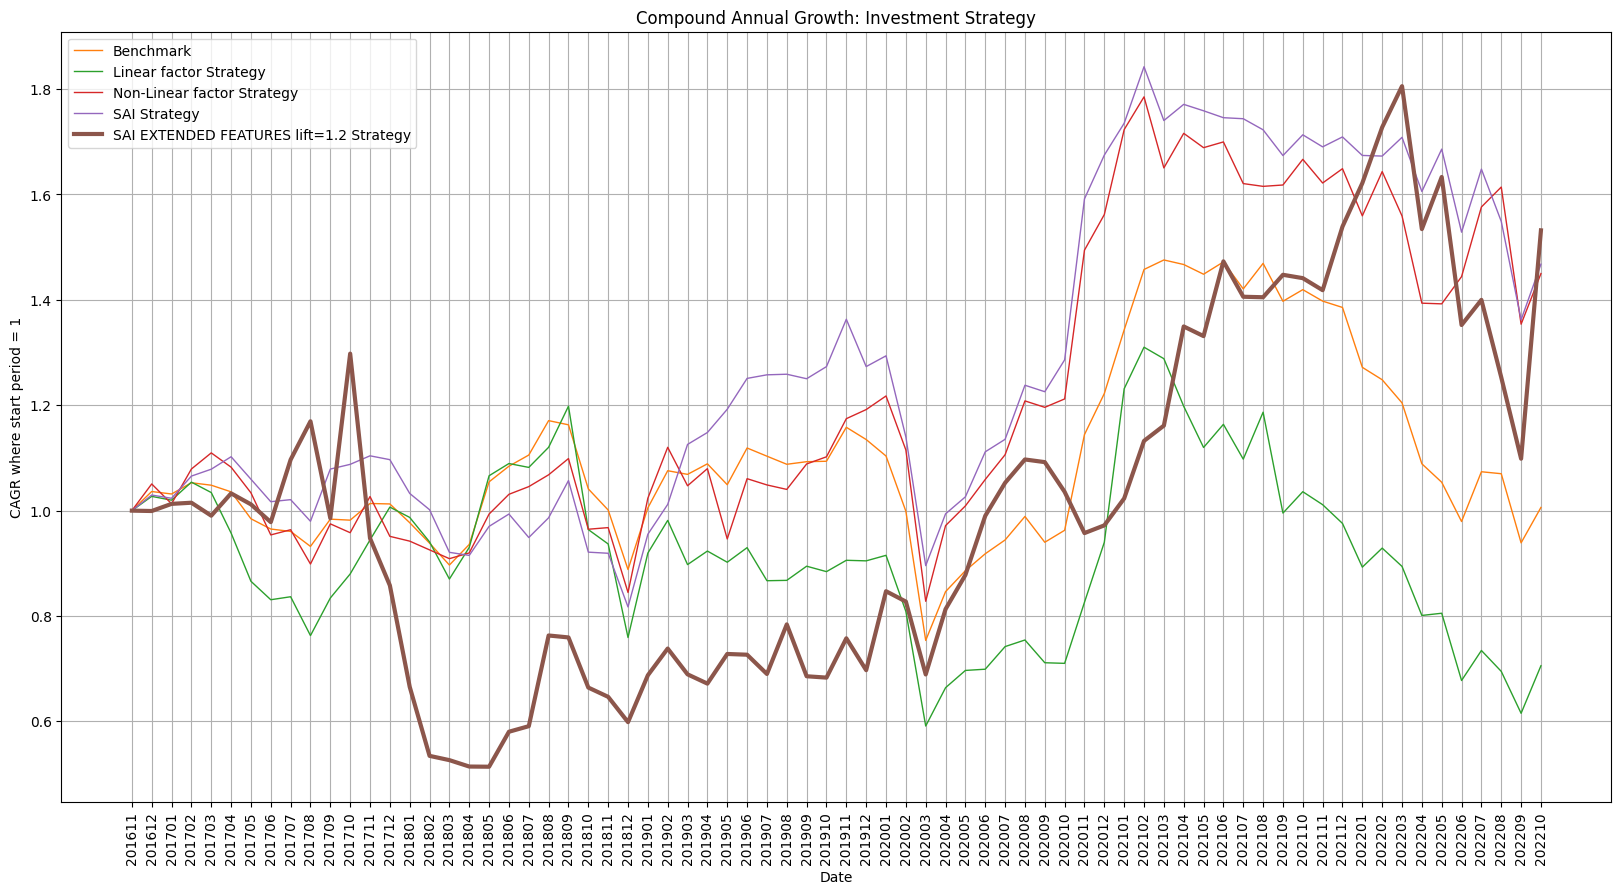

In [45]:
# Run the function to establish simple trades
df_sai_all_features_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_features_all_er,
                                                                         rebalance_freq=6,
                                                                         min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_all_features_trades)),
                 int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),#
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_all_features_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_all_features_trades,
                                        rebalance_freq=6,
                                        df_sec_rets=df_sec_rets,
                                        print_chart=False,
                                        date_start_of_sim=start_date)

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_sai_all_features_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=1.2 Strategy', emphasize=True)
p.legend()
p.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## **SAI All Features Model Results**

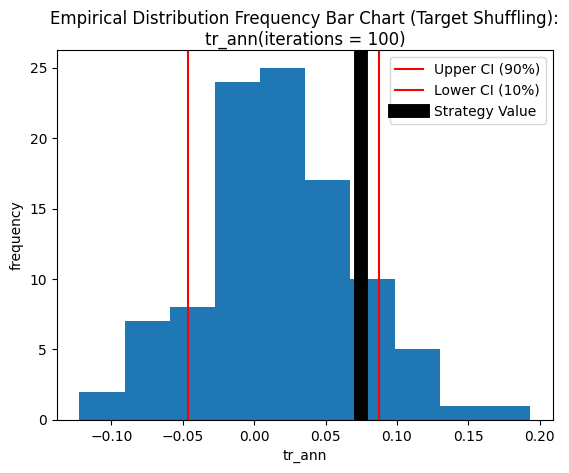

Empirical probability value of the strategy: tr_ann:0.13


In [46]:
# check the performance of the SAI All Features simulation using target shuffling lite, to form an empirical distributon of returns
display(Markdown('## **SAI All Features Model Results**'))
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_sai_all_features_sec_cagr)

We can directly examine the rules driving the latest SAI model

In [47]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_all_features_mod.rules[(sai_all_features_mod.rules['causal_lift']>2)].reset_index(drop=True)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


rules  cond_success_prob  odd_ratio  \
0               (ff_pbk_1, const_1, rmw_3)           0.882353  19.475806   
1                        (ff_pbk_1, rmw_3)           0.740741   7.819549   
2                 (cma_3, hml_1, ff_roe_2)           0.800000   9.846154   
3                        (hml_1, ff_roe_2)           0.750000   7.338462   
4                 (smb_2, mkt-rf_1, rmw_3)           0.750000   7.338462   
5                      (const_1, mkt-rf_1)           0.923077  29.907692   
6              (ff_pbk_1, mkt-rf_1, rmw_3)           0.666667   4.830769   
7                 (smb_2, ff_roe_2, rmw_3)           0.777778   8.833333   
8               (smb_2, const_2, ff_roe_2)           0.823529  11.851852   
9                 (smb_2, ff_pbk_1, rmw_3)           0.800000   9.846154   
10     (smb_2, ff_roe_2, ff_rotc_2, rmw_3)           0.800000   9.846154   
11            (ff_rotc_2, ff_pbk_1, cma_1)           0.736842   7.022222   
12  (ff_rotc_2, ff_pbk_1, cma_1, ff_roe_2)           0.736842   7.022222   
13   (smb_2, const_2, ff_rotc_2, ff_roe_2)           0.857143  14.861538   
14             (smb_2, ff_pbk_1, ff_roe_2)           0.695652   5.845433   
15            (smb_2, ff_pbk_1, ff_rotc_2)           0.666667   4.830769   
16  (smb_2, ff_pbk_1, ff_rotc_2, ff_roe_2)           0.666667   4.830769   

    causal_lift   returns  
0      2.750191  0.049838  
1      2.308802  0.040664  
2      2.493506  0.037589  
3      2.337662  0.032631  
4      2.337662  0.019142  
5      2.877123  0.015226  
6      2.077922  0.014541  
7      2.424242  0.012837  
8      2.566845  0.010400  
9      2.493506  0.007983  
10     2.493506  0.002318  
11     2.296651  0.001622  
12     2.296651  0.001622  
13     2.671614 -0.001218  
14     2.168267 -0.007800  
15     2.077922 -0.018585  
16     2.077922 -0.018585

# Stage4: Model Deployment

Investment model deployment requires a rigorous change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware).
A key part of this stage is monitoring of data drift, and the monitoring of stakeholder KPIs which are principally for investors, and compliance needs.
For investors, the characteristics of the strategy that were marketed and agreed with the investor, should be monitored and reported regularly with sufficient executive oversight and repotring to support it.
For Compliance, regular checking that the investment elements of the strategy are fully compliant with the investment management agreement (IMA), which organisations will tend to have in place as a separate system in any case.


# Stage 5: Model Monitoring and Reporting

## Stage5a: Data Drift

Our model is now in production and being used in practice. We need to monitor its stability. One approach is to monitor the distribution of the input data versus the data the model was trained with . If the distributions have shifted the model outcomes could be invalidated. Here we use our function data_drift_psi to monitor data drift.

Is it time for us to retrain our model?

In [48]:
# Get Data
#================================
sai_train_X, sai_train_y_class, _ = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms,
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=0,  #<< Latest period
                                func_training_period=6,
                                buysell_threshold_quantile=0.333,
                                forecast_ahead=6, #<< Latest period
                                window_size=36) #<< Latest period

sai_test_X, sai_test_y_class, _ = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms,
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=1,  #<< Latest period
                                func_training_period=1,
                                buysell_threshold_quantile=0.333,
                                forecast_ahead=0, #<< Latest period
                                window_size=36) #<< Latest period


# The test data may not contain all the columns in the train data.
# we can add nan columns for the missing columns....
# Add blank column if a column exists in the training data and NOT in the test
missing_cols_to_add = [col for col in sai_test_X.columns if col not in sai_train_X.columns]
sai_train_X[[missing_cols_to_add]] = np.nan
missing_cols_to_add = [col for col in sai_train_X.columns if col not in sai_test_X.columns]
sai_test_X[[missing_cols_to_add]] = np.nan

# Prepare train and test data for data drift check
train_datadrift = sai_train_X # pd.concat([sai_train_X, sai_train_y], axis=1)
test_datadrift = sai_test_X # pd.concat([sai_test_X, sai_test_y], axis=1)

# Data drift check...
data_drift_features = GovernanceUtils.data_drift_psi(train_datadrift, test_datadrift, buckettype='bins',buckets=10,axis=1,single_variable=False)
data_drift_target = data_drift_features[-1]

# Print out the target PSI value:
print("Target PSI value is ",data_drift_target, "\n" )


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


The feature CSI values are:
const *************** CSI value is over 0.2 =  0.9251994183311631
mkt-rf *************** CSI value is over 0.2 =  4.5524569122708884
smb *************** CSI value is over 0.2 =  3.6079068144528046
hml *************** CSI value is over 0.2 =  3.6079068144528046
rmw *************** CSI value is over 0.2 =  2.137548704435189
cma *************** CSI value is over 0.2 =  2.085669325093672
ff_net_mgn *************** CSI value is over 0.2 =  1.4377059192309871
ff_roe *************** CSI value is over 0.2 =  2.2249202220155033
ff_rotc *************** CSI value is over 0.2 =  2.0925686122423675
ff_pbk *************** CSI value is over 0.2 =  0.7476211668606717
Target PSI value is  0.7476211668606717 



## Stage5b: Challenger Models

We have tested three types of equity selecion model in this notebook. We have selected the SAI approach, but we could still use the other models to provide another check on our live model, ie a **challenger model**.


# Afterword

We have done our best to include the key themes of what we think are the critical stages of model development in this notebook, but clearly in practice many more checks and details would be added to each of the 5 model development stages to best ensure stakeholder's KPIs are met, and Governance standards would be as high as possible. Hopefully our example and key themes will provide insight to avoid many of the classic biases in model development.

# References

[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100
 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077

[2] Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

[3] Fabozzi, F. J., Focardi, S. M., & Kolm, P. N. (2010). Quantitative equity investing: Techniques and strategies. John Wiley & Sons.

[4] Israel, R., & Ross, A. (2017). Measuring factor exposures: Uses and abuses. The Journal of Alternative Investments, 20(1), 10-25.

[5] Levin A. (1995). Stock Selection via Nonlinear Multi-Factor Models. Advances in Neural Information Processing Systems, 8.
  https://proceedings.neurips.cc/paper/1995/file/d6ef5f7fa914c19931a55bb262ec879c-Paper.pdf